In [45]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import *
from keras.layers import Activation
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.cross_validation import KFold

In [46]:
batch_size = 128
num_classes = 10
epochs = 20

In [47]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


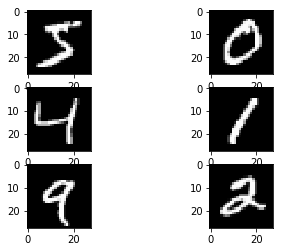

In [48]:
#print the former 6 train images below
import matplotlib.pyplot as plt
plt.subplot(321)
plt.imshow(x_train[0],cmap=plt.get_cmap('gray'))

plt.subplot(322)
plt.imshow(x_train[1],cmap=plt.get_cmap('gray'))

plt.subplot(323)
plt.imshow(x_train[2],cmap=plt.get_cmap('gray'))

plt.subplot(324)
plt.imshow(x_train[3],cmap=plt.get_cmap('gray'))

plt.subplot(325)
plt.imshow(x_train[4],cmap=plt.get_cmap('gray'))

plt.subplot(326)
plt.imshow(x_train[5],cmap=plt.get_cmap('gray'))
plt.show()


In [49]:
if K.image_data_format() == 'channels_first':  ##reshape it so that it is suitable for use training a CNN. 
    #In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [pixels][width][height].
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols).astype('float32')
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype('float32')
    input_shape = (img_rows, img_cols, 1)

In [50]:
# In order to speed up the convergence, we may normalize the input values
# so that they are in the range of (0, 1) for (-1, 1)
# Your code here.
x_train =x_train/255.0
x_test =x_test/255.0

In [51]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [52]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)


In [53]:
# Please build up a simple ConvNets by stacking a few conovlutioanl layers (kenel size with 3x3
# is a good choice, don't foget using non-linear activations for convolutional layers),


In [ ]:
# Extra Points 2: use K-Fold cross-validation for ensembling k models,
# i.e. (1) split the whole training data into K folds;
#      (2) train K models based on different training data;
#      (3) when evaludating the testing data, averaging over K model predictions as final output.
# The codes may look like:
#   for i in range(K):
#       x_train, y_train = ...
#       model_i = train(x_train , y_train)
from sklearn.model_selection import StratifiedKFold

#split traning set into k fold
n_folds = 10
ss = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=5)

In [ ]:
#judge if there is an augmentation
# Please build up a simple ConvNets by stacking a few conovlutioanl layers (kenel size with 3x3
# is a good choice, don't foget using non-linear activations for convolutional layers),
# max-pooling layers, dropout layers and dense/fully-connected layers.
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Out

def train_model(train_x, train_y, test_x, test_y,augmentation=True): 
    model = Sequential()  # create a Sequential model by passing a list of layer instances to the constructor
    model.add(Conv2D(64,(3,3),activation='relu',input_shape=input_shape))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Dropout(0.2))##drop 20% data
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))


    model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),  ##use ADAM here
              metrics=['accuracy'])
     
    if augmentation is True:
        datagen=ImageDataGenerator(
              zoom_range=0.1,
              width_shift_range=0.1,
              height_shift_range=0.1,
              rotation_range=30)
        datagen.fit(x_train)
        
        model.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
        steps_per_epoch= int(len(x_train) / batch_size),
        epochs=epochs, 
        verbose=1,
        validation_data=(test_x, test_y))
        print("Training complete!")
        
    else:
        
        model.fit(train_x, train_y, batch_size=batch_size,
                 epochs=epochs, verbose=0, validation_data=(test_x, test_y))
    
        print("Training complete")
        
        
    return model


ensemble_models = []

for train, test in ss.split(x_train, np.argmax(y_train, 1)):  #print the i th ensemble models are training 
    ensemble_models.append(train_model(x_train[train], y_train[train], x_train[test], y_train[test]))
    print('Number of models: {}'.format(len(ensemble_models)))

    
def predict(x_test):
    predictions = np.array([model.predict(x_test) for model in ensemble_models])
    return np.mean(predictions, axis=0)

def accuracy(prediction, y_test):
    prediction = np.argmax(prediction, axis=1)
    labels = np.argmax(y_test, axis=1)
    return np.mean(prediction == labels)

prediction = predict(x_test)
accuracy(prediction, y_test)

Epoch 1/20
468/468 [==============================] - 20s - loss: 0.5872 - acc: 0.8091 - val_loss: 0.0732 - val_acc: 0.9787
Epoch 2/20
468/468 [==============================] - 17s - loss: 0.1769 - acc: 0.9452 - val_loss: 0.0491 - val_acc: 0.9842
Epoch 3/20
468/468 [==============================] - 17s - loss: 0.1277 - acc: 0.9607 - val_loss: 0.0372 - val_acc: 0.9867
Epoch 4/20
468/468 [==============================] - 17s - loss: 0.1040 - acc: 0.9667 - val_loss: 0.0332 - val_acc: 0.9895
Epoch 5/20
468/468 [==============================] - 17s - loss: 0.0928 - acc: 0.9710 - val_loss: 0.0292 - val_acc: 0.9905
Epoch 6/20
468/468 [==============================] - 17s - loss: 0.0818 - acc: 0.9749 - val_loss: 0.0289 - val_acc: 0.9905
Epoch 7/20
468/468 [==============================] - 17s - loss: 0.0728 - acc: 0.9773 - val_loss: 0.0246 - val_acc: 0.9918
Epoch 8/20
468/468 [==============================] - 17s - loss: 0.0701 - acc: 0.9784 - val_loss: 0.0247 - val_acc: 0.9920
Epoch 9/

468/468 [==============================] - 18s - loss: 0.0501 - acc: 0.9841 - val_loss: 0.0268 - val_acc: 0.9915
Epoch 15/20
468/468 [==============================] - 18s - loss: 0.0500 - acc: 0.9843 - val_loss: 0.0256 - val_acc: 0.9927
Epoch 16/20
468/468 [==============================] - 18s - loss: 0.0480 - acc: 0.9853 - val_loss: 0.0204 - val_acc: 0.9940
Epoch 17/20
468/468 [==============================] - 18s - loss: 0.0467 - acc: 0.9856 - val_loss: 0.0232 - val_acc: 0.9923
Epoch 18/20
468/468 [==============================] - 18s - loss: 0.0469 - acc: 0.9853 - val_loss: 0.0230 - val_acc: 0.9923
Epoch 19/20
468/468 [==============================] - 18s - loss: 0.0439 - acc: 0.9865 - val_loss: 0.0208 - val_acc: 0.9928
Epoch 20/20
468/468 [==============================] - 18s - loss: 0.0421 - acc: 0.9871 - val_loss: 0.0209 - val_acc: 0.9937
Training complete!
Number of models: 4
Epoch 1/20
468/468 [==============================] - 19s - loss: 0.0459 - acc: 0.9857 - val_loss:

468/468 [==============================] - 19s - loss: 0.0497 - acc: 0.9846 - val_loss: 0.0327 - val_acc: 0.9910
Epoch 16/20
468/468 [==============================] - 19s - loss: 0.0527 - acc: 0.9840 - val_loss: 0.0269 - val_acc: 0.9922
Epoch 17/20
468/468 [==============================] - 19s - loss: 0.0477 - acc: 0.9853 - val_loss: 0.0280 - val_acc: 0.9932
Epoch 18/20
468/468 [==============================] - 19s - loss: 0.0473 - acc: 0.9847 - val_loss: 0.0287 - val_acc: 0.9925
Epoch 19/20
468/468 [==============================] - 19s - loss: 0.0461 - acc: 0.9863 - val_loss: 0.0249 - val_acc: 0.9937
Epoch 20/20
468/468 [==============================] - 19s - loss: 0.0452 - acc: 0.9858 - val_loss: 0.0277 - val_acc: 0.9920
Training complete!
Number of models: 8
Epoch 1/20
468/468 [==============================] - 20s - loss: 0.5887 - acc: 0.8077 - val_loss: 0.0791 - val_acc: 0.9728
Epoch 2/20
468/468 [==============================] - 19s - loss: 0.1718 - acc: 0.9463 - val_loss: 

0.99609999999999999